In [1]:
%matplotlib inline

import glob
from io import StringIO
import matplotlib
from matplotlib import pyplot
import numpy
import os
import pandas
from plumbum import local
from scipy import stats
import seaborn

pandas.options.display.max_columns = None
pandas.options.display.max_rows = None

## Read in peak coordinates for all tissues

In [149]:
worm_peak_paths = sorted(glob.glob('../files_for_geo/*colors.bed'))
worm_peak_dfs = []
for path in worm_peak_paths:
    tissue = path.split('_')[-2]
    tissue_df = pandas.read_csv(path, sep='\t', names=['chrom', 'start', 'end', 'name', 'score', 
                                                       'strand', 'start2', 'start3', 'color'])
    tissue_df['tissue'] = tissue
    worm_peak_dfs.append(tissue_df[['chrom', 'start', 'end', 'name', 'tissue', 'score', 'color']].copy())
worm_peak_df = pandas.concat(worm_peak_dfs)
print(worm_peak_df.shape)
worm_peak_df.head()

(135998, 7)


,chrom,start,end,name,tissue,score,color
0,chrI,3708,4080,4_peak_1,coelomocyte,195,"167,86,41"
1,chrI,16910,17184,4_peak_2,coelomocyte,118,"167,86,41"
2,chrI,26987,27296,4_peak_3,coelomocyte,136,"167,86,41"
3,chrI,39683,39986,4_peak_4,coelomocyte,127,"167,86,41"
4,chrI,69968,70271,4_peak_5,coelomocyte,178,"167,86,41"


In [150]:
#calculate the number of overlapping tissues for each peak
tissue_types = sorted(set(worm_peak_df['tissue'].to_numpy()))

tissue_overlap_cols = []
for tissue_type in tissue_types:
    tissue_overlap_cols.append('{!s}_overlaps'.format(tissue_type))
    worm_peak_df[tissue_overlap_cols[-1]] = [worm_peak_df[(worm_peak_df['tissue'] == tissue_type)
                                                          & (worm_peak_df['chrom'] == worm_peak_df.iloc[idx]['chrom'])
                                                          & ((worm_peak_df['end'] > worm_peak_df.iloc[idx]['start'])
                                                          & (worm_peak_df['start'] < worm_peak_df.iloc[idx]['end']))].shape[0]
                                             for idx in range(worm_peak_df.shape[0])]
worm_peak_df['num_overlaps'] = worm_peak_df[tissue_overlap_cols].to_numpy().sum(axis=1)
worm_peak_df.head()

KeyboardInterrupt: 

In [152]:
worm_peak_df['peak_name'] = worm_peak_df.apply(lambda x: '{!s}_{!s}_{!s}_{!s}'.format(x['peak_name'], x['chrom'], x['start'], x['stop']),
                                               axis=1)
worm_peak_df.head()

,chrom,start,stop,peak_name,tissue,score,color,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,num_overlaps
0,chrI,3328,4201,peak2a_chrI_3328_4201,gonad,320,"249,127,192",1,1,1,1,1,1,1,1,1,9
1,chrI,3343,4186,peak1_chrI_3343_4186,intestine,373,"252,216,0",1,1,1,1,1,1,1,1,1,9
2,chrI,3545,4129,peak1_chrI_3545_4129,hypodermis,253,"78,174,74",1,1,1,1,1,1,1,1,1,9
3,chrI,3614,4094,peak1_chrI_3614_4094,neuron,134,"152,78,163",1,1,1,1,1,1,1,1,1,9
4,chrI,3616,4114,40_peak_1_chrI_3616_4114,muscle,229,"229,26,30",1,1,1,1,1,1,1,1,1,9


In [153]:
all_peaks_path = './all_whole_worm_peaks.bed'
all_peaks_str = worm_peak_df.to_csv(sep='\t', index=False, header=False)
sort_and_write_cmd = local['bedtools']['sort', '-i', 'stdin'] << all_peaks_str > all_peaks_path
sort_and_write_cmd()

''

### Start here if all_whole_worm_peaks.bed is already written

In [2]:
all_peaks_path = './all_whole_worm_peaks.bed'
worm_peak_df = pandas.read_csv(all_peaks_path, sep='\t', names=['chrom', 'start', 'stop', 'peak_name', 'tissue',
                                                                'score', 'color', 'coelomocyte_overlaps', 
                                                                'glia_overlaps', 'gonad_overlaps', 'hypodermis_overlaps', 
                                                                'intestine_overlaps', 'muscle_overlaps',
                                                                'neuron_overlaps', 'pharynx_overlaps', 
                                                                'sexmyoblast_overlaps', 'num_overlaps'])
print(worm_peak_df.shape)
worm_peak_df.head()

(135998, 17)


,chrom,start,stop,peak_name,tissue,score,color,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,num_overlaps
0,chrI,3328,4201,peak2a_chrI_3328_4201,gonad,320,"249,127,192",1,1,1,1,1,1,1,1,1,9
1,chrI,3343,4186,peak1_chrI_3343_4186,intestine,373,"252,216,0",1,1,1,1,1,1,1,1,1,9
2,chrI,3545,4129,peak1_chrI_3545_4129,hypodermis,253,"78,174,74",1,1,1,1,1,1,1,1,1,9
3,chrI,3614,4094,peak1_chrI_3614_4094,neuron,134,"152,78,163",1,1,1,1,1,1,1,1,1,9
4,chrI,3616,4114,40_peak_1_chrI_3616_4114,muscle,229,"229,26,30",1,1,1,1,1,1,1,1,1,9


## Read in the gff3 annotations and restrict to WormBase annotations.

In [3]:
annot_path = 'ATAC_sequencing/2018_worm_atac/ref_data/WS235/c_elegans.PRJNA13758.WS272.annotations.gff3.gz'
all_annots = pandas.read_csv(annot_path, sep='\t', 
                             names=['seqid', 'source', 'type', 'start', 'end', 
                                    'score', 'strand', 'phase', 'attributes'],
                             comment='#')
print(all_annots.shape)
all_annots.head()

(29200652, 9)


,seqid,source,type,start,end,score,strand,phase,attributes
0,I,BLAT_EST_OTHER,expressed_sequence_match,1,50,12.8,-,.,ID=yk585b5.5.6;Target=yk585b5.5 119 168 +
1,I,BLAT_Trinity_OTHER,expressed_sequence_match,1,52,20.4,+,.,ID=elegans_PE_SS_GG6116|c0_g1_i1.2;Target=eleg...
2,I,inverted,inverted_repeat,1,212,66,.,.,Note=loop 426
3,I,Genbank,assembly_component,1,2679,.,+,.,genbank=FO080985
4,I,Genomic_canonical,assembly_component,1,2679,.,+,.,"Name=cTel33B;Note=Clone:cTel33B,GenBank:FO080985"


In [4]:
chr_dict = {'I':'chrI', 'II':'chrII', 'III':'chrIII', 'IV':'chrIV', 'V':'chrV', 'MtDNA':'chrM', 'X':'chrX'}
all_annots['seqid_non-ucsc'] = all_annots['seqid'].copy()
all_annots['seqid'] = [chr_dict[elt] for elt in all_annots['seqid_non-ucsc'].to_numpy()]

In [5]:
wormbase_annots = all_annots[all_annots['source'] == 'WormBase'].copy()
wormbase_annots['type'] = wormbase_annots['type'].astype('category')
print(wormbase_annots['type'].cat.categories)
print(wormbase_annots.shape)
wormbase_annots.head()

Index(['CDS', 'antisense_RNA', 'exon', 'five_prime_UTR', 'gene', 'intron',
       'lincRNA', 'mRNA', 'miRNA', 'miRNA_primary_transcript', 'ncRNA',
       'nc_primary_transcript', 'piRNA', 'pre_miRNA', 'pseudogenic_rRNA',
       'pseudogenic_tRNA', 'pseudogenic_transcript', 'rRNA', 'scRNA', 'snRNA',
       'snoRNA', 'tRNA', 'three_prime_UTR'],
      dtype='object')
(824814, 10)


,seqid,source,type,start,end,score,strand,phase,attributes,seqid_non-ucsc
494,chrI,WormBase,gene,3747,3909,.,-,.,ID=Gene:WBGene00023193;Name=WBGene00023193;int...,I
495,chrI,WormBase,snoRNA,3747,3909,.,-,.,ID=Transcript:Y74C9A.6;Parent=Gene:WBGene00023...,I
496,chrI,WormBase,exon,3747,3909,.,-,.,Parent=Transcript:Y74C9A.6,I
642,chrI,WormBase,gene,4116,10230,.,-,.,ID=Gene:WBGene00022277;Name=WBGene00022277;loc...,I
643,chrI,WormBase,mRNA,4116,10230,.,-,.,ID=Transcript:Y74C9A.3.1;Parent=Gene:WBGene000...,I


### Extract gene and transcript ID info from the attributes field

In [6]:
split_attrs = [dict([elt.split('=') for elt in attr_str.split(';')])
               for attr_str in wormbase_annots['attributes'].to_numpy()]
transcript_id = []
pseudogene_id = []
gene_id = []
biotype = []
tx_to_gene = {}
ps_to_gene = {}
gene_to_biotype = {}
for attr_dict in split_attrs:
    if attr_dict.get('ID', '').startswith('Transcript') and attr_dict['Parent'].startswith('Gene'):
        tx_to_gene[attr_dict['ID']] = attr_dict['Parent']
    elif attr_dict.get('ID', '').startswith('Pseudogene') and attr_dict['Parent'].startswith('Gene'):
        ps_to_gene[attr_dict['ID']] = attr_dict['Parent']
    elif attr_dict.get('ID', '').startswith('Gene'):
        gene_to_biotype[attr_dict['ID']] = attr_dict['biotype']
    
    if 'ID' in attr_dict:
        transcript_id.append(attr_dict['ID'] if attr_dict['ID'].startswith('Transcript') else numpy.nan)
        pseudogene_id.append(attr_dict['ID'] if attr_dict['ID'].startswith('Pseudogene') else numpy.nan)
        gene_id.append(attr_dict['ID'] if attr_dict['ID'].startswith('Gene') 
                       else (tx_to_gene[attr_dict['ID'].split(',')[0]]
                             if attr_dict['ID'].startswith('Transcript')
                             else (ps_to_gene[attr_dict['ID']]
                                   if attr_dict['ID'].startswith('Pseudogene')
                                   else numpy.nan)))
        biotype.append(gene_to_biotype.get(gene_id[-1], numpy.nan))
    else:
        transcript_id.append(attr_dict['Parent'] if attr_dict['Parent'].startswith('Transcript') else numpy.nan)
        pseudogene_id.append(attr_dict['Parent'] if attr_dict['Parent'].startswith('Pseudogene') else numpy.nan)
        gene_id.append(tx_to_gene[attr_dict['Parent']] 
                       if attr_dict['Parent'].startswith('Transcript') 
                       else (ps_to_gene[attr_dict['Parent']]
                             if attr_dict['Parent'].startswith('Pseudogene')
                             else numpy.nan))
        biotype.append(gene_to_biotype.get(gene_id[-1], numpy.nan))

wormbase_annots['biotype'] = biotype
wormbase_annots['gene_id'] = gene_id
wormbase_annots['transcript_id'] = transcript_id
wormbase_annots['pseudogene_id'] = pseudogene_id

print(wormbase_annots.shape)
wormbase_annots.head()

(824814, 14)


,seqid,source,type,start,end,score,strand,phase,attributes,seqid_non-ucsc,biotype,gene_id,transcript_id,pseudogene_id
494,chrI,WormBase,gene,3747,3909,.,-,.,ID=Gene:WBGene00023193;Name=WBGene00023193;int...,I,snoRNA,Gene:WBGene00023193,NaN,NaN
495,chrI,WormBase,snoRNA,3747,3909,.,-,.,ID=Transcript:Y74C9A.6;Parent=Gene:WBGene00023...,I,snoRNA,Gene:WBGene00023193,Transcript:Y74C9A.6,NaN
496,chrI,WormBase,exon,3747,3909,.,-,.,Parent=Transcript:Y74C9A.6,I,snoRNA,Gene:WBGene00023193,Transcript:Y74C9A.6,NaN
642,chrI,WormBase,gene,4116,10230,.,-,.,ID=Gene:WBGene00022277;Name=WBGene00022277;loc...,I,protein_coding,Gene:WBGene00022277,NaN,NaN
643,chrI,WormBase,mRNA,4116,10230,.,-,.,ID=Transcript:Y74C9A.3.1;Parent=Gene:WBGene000...,I,protein_coding,Gene:WBGene00022277,Transcript:Y74C9A.3.1,NaN


### Write just the WormBase gff3 features to disk to use in closest peak analysis

In [7]:
wormbase_annots_path = './wormbase_annots.no_cds_and_no_ncRNA_genes_lt_500bp.exons.gff3'
gff3_cols = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
short_ncRNA_genes = wormbase_annots.loc[(wormbase_annots['type'] == 'ncRNA') 
                                        & ((wormbase_annots['end'] - wormbase_annots['start']) < 500), 'gene_id'].to_numpy()
row_idx = (wormbase_annots['type'] == 'exon') & (~wormbase_annots['gene_id'].isin(short_ncRNA_genes))
print(row_idx.sum())
wormbase_annots_str = wormbase_annots.loc[row_idx, gff3_cols].to_csv(sep='\t', index=False, header=False)
sort_and_write_cmd = (local['bedtools']['sort', '-i', 'stdin'] << wormbase_annots_str) > wormbase_annots_path
sort_and_write_cmd()

262478


''

## For each peak, find the nearest downstream WormBase feature, including directly overlapping features

In [8]:
#get overlaps for peaks completely contained in exons
peaks_in_exons_cmd = (local['bedtools']['intersect', '-f', '1.0', '-wao', '-a', all_peaks_path, '-b', wormbase_annots_path])
peaks_in_exons_res_str = peaks_in_exons_cmd()
peaks_in_exons_res = pandas.read_csv(StringIO(peaks_in_exons_res_str), sep='\t', header=None)
peaks_in_exons_res.columns = ['peak_chrom', 'peak_start', 'peak_end', 'peak_name', 'peak_tissue', 'peak_score', 'peak_color', 
                         'coelomocyte_overlaps', 'glia_overlaps', 'gonad_overlaps', 'hypodermis_overlaps', 
                         'intestine_overlaps', 'muscle_overlaps', 'neuron_overlaps', 'pharynx_overlaps', 
                         'sexmyoblast_overlaps', 'peak_overlap',
                         'seqid', 'source', 'type', 'start', 'end', 'score', 
                         'strand', 'phase', 'attr', 'dist']
print(peaks_in_exons_res.shape)
peaks_in_exons_res = peaks_in_exons_res[peaks_in_exons_res['dist'] > 0]
print(peaks_in_exons_res.shape)
peaks_in_exons_res['dist'] = 0
peaks_in_exons_res.head()

(146602, 27)
(17863, 27)


,peak_chrom,peak_start,peak_end,peak_name,peak_tissue,peak_score,peak_color,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,peak_overlap,seqid,source,type,start,end,score,strand,phase,attr,dist
28,chrI,16569,16766,peak5a_chrI_16569_16766,gonad,100,"249,127,192",0,0,1,0,2,0,1,0,0,4,chrI,WormBase,exon,16473,16837,.,+,.,Parent=Transcript:Y74C9A.2a.4,0
29,chrI,16569,16766,peak5a_chrI_16569_16766,gonad,100,"249,127,192",0,0,1,0,2,0,1,0,0,4,chrI,WormBase,exon,16473,16837,.,+,.,Parent=Transcript:Y74C9A.2b.1,0
30,chrI,16569,16766,peak5a_chrI_16569_16766,gonad,100,"249,127,192",0,0,1,0,2,0,1,0,0,4,chrI,WormBase,exon,16473,16837,.,+,.,Parent=Transcript:Y74C9A.2a.5,0
31,chrI,16569,16766,peak5a_chrI_16569_16766,gonad,100,"249,127,192",0,0,1,0,2,0,1,0,0,4,chrI,WormBase,exon,16473,16837,.,+,.,Parent=Transcript:Y74C9A.2a.2,0
32,chrI,16569,16766,peak5a_chrI_16569_16766,gonad,100,"249,127,192",0,0,1,0,2,0,1,0,0,4,chrI,WormBase,exon,16473,16837,.,+,.,Parent=Transcript:Y74C9A.2a.1,0


In [9]:
#intersect with non-exons to split off the non-exons parts of the peaks, then do closest downstream exon assignment,
#then re-intersect with the exons to get the exon info.
genome_lens_path = 'ATAC_sequencing/2018_worm_atac/ref_data/WS235/c_elegans.WS235.chrom.sizes'
intersect_res_cmd = (local['bedtools']['complement', '-i', wormbase_annots_path, '-g', genome_lens_path]
                     | local['bedtools']['intersect', '-a', all_peaks_path, '-b', 'stdin']
                     | local['bedtools']['sort', '-i', 'stdin']
                     | local['bedtools']['closest', '-D', 'b', '-id', '-io', '-a', 'stdin', '-b', wormbase_annots_path])
intersect_res_str = intersect_res_cmd()
intersect_res = pandas.read_csv(StringIO(intersect_res_str), sep='\t', header=None)
intersect_res.columns = ['peak_chrom', 'peak_start', 'peak_end', 'peak_name', 'peak_tissue', 'peak_score', 'peak_color', 
                         'coelomocyte_overlaps', 'glia_overlaps', 'gonad_overlaps', 'hypodermis_overlaps', 
                         'intestine_overlaps', 'muscle_overlaps', 'neuron_overlaps', 'pharynx_overlaps', 
                         'sexmyoblast_overlaps', 'peak_overlap',
                         'seqid', 'source', 'type', 'start', 'end', 'score', 
                         'strand', 'phase', 'attr', 'dist']
print(intersect_res.shape)
intersect_res = pandas.concat([intersect_res, peaks_in_exons_res]).sort_values(by=['peak_chrom', 'peak_start', 'peak_end',
                                                                                   'peak_tissue', 'attr'])
print(intersect_res.shape)
intersect_res.head()

(285367, 27)
(303230, 27)


,peak_chrom,peak_start,peak_end,peak_name,peak_tissue,peak_score,peak_color,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,peak_overlap,seqid,source,type,start,end,score,strand,phase,attr,dist
0,chrI,3328,3746,peak2a_chrI_3328_4201,gonad,320,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.1,-7749
1,chrI,3328,3746,peak2a_chrI_3328_4201,gonad,320,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.3,-7749
2,chrI,3343,3746,peak1_chrI_3343_4186,intestine,373,"252,216,0",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.1,-7749
3,chrI,3343,3746,peak1_chrI_3343_4186,intestine,373,"252,216,0",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.3,-7749
4,chrI,3545,3746,peak1_chrI_3545_4129,hypodermis,253,"78,174,74",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.1,-7749


### add in the additional wormbase_annots fields that are not in the standard GFF3 format

In [10]:
intersect_res_attr_expand = intersect_res.join(wormbase_annots[['seqid', 'source', 'type', 'start', 'end', 
                                                                'biotype', 'gene_id', 'transcript_id', 'pseudogene_id']]
                                               .set_index(['seqid', 'source', 'type', 'start', 'end']),
                                               on=['seqid', 'source', 'type', 'start', 'end']).reset_index().drop(columns=['index'])
print(intersect_res_attr_expand.shape)
intersect_res_attr_expand.head()

(1286002, 31)


,peak_chrom,peak_start,peak_end,peak_name,peak_tissue,peak_score,peak_color,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,peak_overlap,seqid,source,type,start,end,score,strand,phase,attr,dist,biotype,gene_id,transcript_id,pseudogene_id
0,chrI,3328,3746,peak2a_chrI_3328_4201,gonad,320,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.1,-7749,protein_coding,Gene:WBGene00022276,Transcript:Y74C9A.2a.3,NaN
1,chrI,3328,3746,peak2a_chrI_3328_4201,gonad,320,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.1,-7749,protein_coding,Gene:WBGene00022276,Transcript:Y74C9A.2a.1,NaN
2,chrI,3328,3746,peak2a_chrI_3328_4201,gonad,320,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.3,-7749,protein_coding,Gene:WBGene00022276,Transcript:Y74C9A.2a.3,NaN
3,chrI,3328,3746,peak2a_chrI_3328_4201,gonad,320,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.3,-7749,protein_coding,Gene:WBGene00022276,Transcript:Y74C9A.2a.1,NaN
4,chrI,3343,3746,peak1_chrI_3343_4186,intestine,373,"252,216,0",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.1,-7749,protein_coding,Gene:WBGene00022276,Transcript:Y74C9A.2a.3,NaN


## Collapse peaks split over exons and duplicate entries due to transcript annotations

In [11]:
matching_tx = intersect_res_attr_expand.apply(lambda x: ((x['transcript_id'] in x['attr']) 
                                                          if not isinstance(x['transcript_id'], float) 
                                                          else (x['pseudogene_id'] in x['attr'])), axis=1)
intersect_res_attr_expand = intersect_res_attr_expand[matching_tx]
print(intersect_res_attr_expand.shape)
intersect_res_attr_expand.head()

(303246, 31)


,peak_chrom,peak_start,peak_end,peak_name,peak_tissue,peak_score,peak_color,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,peak_overlap,seqid,source,type,start,end,score,strand,phase,attr,dist,biotype,gene_id,transcript_id,pseudogene_id
1,chrI,3328,3746,peak2a_chrI_3328_4201,gonad,320,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.1,-7749,protein_coding,Gene:WBGene00022276,Transcript:Y74C9A.2a.1,NaN
2,chrI,3328,3746,peak2a_chrI_3328_4201,gonad,320,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.3,-7749,protein_coding,Gene:WBGene00022276,Transcript:Y74C9A.2a.3,NaN
5,chrI,3343,3746,peak1_chrI_3343_4186,intestine,373,"252,216,0",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.1,-7749,protein_coding,Gene:WBGene00022276,Transcript:Y74C9A.2a.1,NaN
6,chrI,3343,3746,peak1_chrI_3343_4186,intestine,373,"252,216,0",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.3,-7749,protein_coding,Gene:WBGene00022276,Transcript:Y74C9A.2a.3,NaN
9,chrI,3545,3746,peak1_chrI_3545_4129,hypodermis,253,"78,174,74",1,1,1,1,1,1,1,1,1,9,chrI,WormBase,exon,11495,11561,.,+,.,Parent=Transcript:Y74C9A.2a.1,-7749,protein_coding,Gene:WBGene00022276,Transcript:Y74C9A.2a.1,NaN


In [12]:
closest_exon_per_peak = intersect_res_attr_expand.groupby(['peak_name', 'peak_tissue', 'gene_id'])['dist'].max().reset_index()
intersect_res_attr_expand = intersect_res_attr_expand.set_index(['peak_name', 'peak_tissue', 'gene_id', 'dist']).loc[closest_exon_per_peak.set_index(['peak_name', 'peak_tissue', 'gene_id', 'dist']).index].reset_index()
print(intersect_res_attr_expand.shape)

(274305, 31)


In [13]:
intersect_res_attr_expand = intersect_res_attr_expand[[col for col in intersect_res_attr_expand.columns if not col in ['attr', 'transcript_id', 'pseudogene_id', 'peak_start', 'peak_end', 'start', 'end']]].drop_duplicates()
print(intersect_res_attr_expand.shape)
intersect_res_attr_expand.head(100)

(146909, 24)


,peak_name,peak_tissue,gene_id,dist,peak_chrom,peak_score,peak_color,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,peak_overlap,seqid,source,type,score,strand,phase,biotype
0,37_peak_1000_chrII_8783538_8783821,sexmyoblast,Gene:WBGene00004790,-1,chrII,182,"249,127,192",0,1,0,0,0,1,1,0,1,4,chrII,WormBase,exon,.,-,.,protein_coding
1,37_peak_1001_chrII_8784399_8784605,sexmyoblast,Gene:WBGene00014307,-1,chrII,131,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrII,WormBase,exon,.,+,.,pseudogene
3,37_peak_1002_chrII_8786064_8786264,sexmyoblast,Gene:WBGene00014308,-193,chrII,130,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrII,WormBase,exon,.,+,.,pseudogene
4,37_peak_1003_chrII_8787233_8787763,sexmyoblast,Gene:WBGene00014309,-7,chrII,286,"249,127,192",1,1,2,1,1,1,1,1,1,10,chrII,WormBase,exon,.,+,.,pseudogene
6,37_peak_1004_chrII_8789061_8789261,sexmyoblast,Gene:WBGene00014309,0,chrII,131,"249,127,192",0,0,0,1,1,1,1,0,1,5,chrII,WormBase,exon,.,+,.,pseudogene
8,37_peak_1005_chrII_8846307_8846563,sexmyoblast,Gene:WBGene00011767,-498,chrII,148,"249,127,192",0,0,0,2,2,1,0,0,1,6,chrII,WormBase,exon,.,+,.,protein_coding
9,37_peak_1006_chrII_8846653_8846918,sexmyoblast,Gene:WBGene00011767,-143,chrII,166,"249,127,192",0,1,0,1,1,1,1,1,1,7,chrII,WormBase,exon,.,+,.,protein_coding
10,37_peak_1007a_chrII_8931421_8931681,sexmyoblast,Gene:WBGene00011884,-415,chrII,183,"249,127,192",2,1,2,1,2,1,1,2,1,13,chrII,WormBase,exon,.,+,.,protein_coding
11,37_peak_1007b_chrII_8931682_8932187,sexmyoblast,Gene:WBGene00011884,-1,chrII,235,"249,127,192",1,1,1,1,1,2,2,1,1,11,chrII,WormBase,exon,.,+,.,protein_coding
12,37_peak_1008a_chrII_8933819_8934199,sexmyoblast,Gene:WBGene00011885,-183,chrII,148,"249,127,192",1,0,2,1,2,2,2,0,1,11,chrII,WormBase,exon,.,+,.,protein_coding


### Make some helper columns with useful calculated values

In [15]:
peak_coords = list(zip(*[[int(coord) for coord in pname.split('_')[-2:]]
                         for pname in intersect_res_attr_expand['peak_name']]))
intersect_res_attr_expand['peak_start'] = numpy.array(peak_coords[0], dtype=int)
intersect_res_attr_expand['peak_end'] = numpy.array(peak_coords[1], dtype=int)
intersect_res_attr_expand['within_2kb'] = intersect_res_attr_expand['dist'] > -2000
intersect_res_attr_expand['within_1.2kb'] = intersect_res_attr_expand['dist'] > -1200
intersect_res_attr_expand['peak_id'] = ['{!s}-{!s}'.format(*elt) for elt in intersect_res_attr_expand[['peak_name', 'peak_tissue']].to_numpy()]
intersect_res_attr_expand['peak_len'] = intersect_res_attr_expand['peak_end'] - intersect_res_attr_expand['peak_start']
peak_centers = ((intersect_res_attr_expand['peak_end'] - intersect_res_attr_expand['peak_start'])//2) + intersect_res_attr_expand['peak_start']
intersect_res_attr_expand['center250_start'] = peak_centers - 125
intersect_res_attr_expand['center250_end'] = peak_centers + 125
intersect_res_attr_expand.head()

,peak_name,peak_tissue,gene_id,dist,peak_chrom,peak_score,peak_color,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,peak_overlap,seqid,source,type,score,strand,phase,biotype,peak_start,peak_end,within_2kb,within_1.2kb,peak_id,peak_len,center250_start,center250_end
0,37_peak_1000_chrII_8783538_8783821,sexmyoblast,Gene:WBGene00004790,-1,chrII,182,"249,127,192",0,1,0,0,0,1,1,0,1,4,chrII,WormBase,exon,.,-,.,protein_coding,8783538,8783821,True,True,37_peak_1000_chrII_8783538_8783821-sexmyoblast,283,8783554,8783804
1,37_peak_1001_chrII_8784399_8784605,sexmyoblast,Gene:WBGene00014307,-1,chrII,131,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrII,WormBase,exon,.,+,.,pseudogene,8784399,8784605,True,True,37_peak_1001_chrII_8784399_8784605-sexmyoblast,206,8784377,8784627
3,37_peak_1002_chrII_8786064_8786264,sexmyoblast,Gene:WBGene00014308,-193,chrII,130,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrII,WormBase,exon,.,+,.,pseudogene,8786064,8786264,True,True,37_peak_1002_chrII_8786064_8786264-sexmyoblast,200,8786039,8786289
4,37_peak_1003_chrII_8787233_8787763,sexmyoblast,Gene:WBGene00014309,-7,chrII,286,"249,127,192",1,1,2,1,1,1,1,1,1,10,chrII,WormBase,exon,.,+,.,pseudogene,8787233,8787763,True,True,37_peak_1003_chrII_8787233_8787763-sexmyoblast,530,8787373,8787623
6,37_peak_1004_chrII_8789061_8789261,sexmyoblast,Gene:WBGene00014309,0,chrII,131,"249,127,192",0,0,0,1,1,1,1,0,1,5,chrII,WormBase,exon,.,+,.,pseudogene,8789061,8789261,True,True,37_peak_1004_chrII_8789061_8789261-sexmyoblast,200,8789036,8789286


## Visualize the distribution of distances from peak to nearest exon

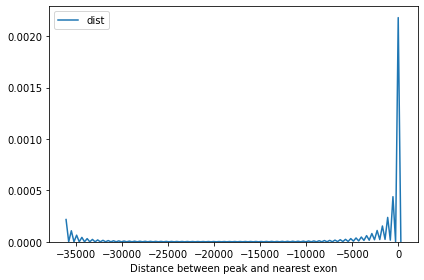

In [16]:
to_plot = intersect_res_attr_expand

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4))
seaborn.kdeplot(data=to_plot['dist'], ax=axes)
axes.set_xlabel('Distance between peak and nearest exon')
fig.tight_layout()

## Extract gene name info into a mapping between wormbase ID and common_name and add it to the intersect result

In [17]:
#add a column with locus, sequence_name, and then a prioritized common_name (locus if available, else sequence_name)
wb_id_mapping = {'gene_id':[],
                 'locus':[],
                 'sequence_name':[]}
just_genes = wormbase_annots[(wormbase_annots['type'] == 'gene') 
                             & (wormbase_annots['gene_id'].isin(intersect_res_attr_expand['gene_id']))]
for attr_str in just_genes['attributes'].to_numpy():
    attr_dict = dict([elt.split('=') for elt in attr_str.split(';')])
    wb_id_mapping['gene_id'].append(attr_dict['ID'])
    wb_id_mapping['locus'].append(attr_dict.get('locus', numpy.nan))
    wb_id_mapping['sequence_name'].append(attr_dict.get('sequence_name', numpy.nan))
wb_id_map = pandas.DataFrame(wb_id_mapping).drop_duplicates()
wb_id_map['common_name'] = wb_id_map['locus'].copy()
wb_id_map.loc[wb_id_map['locus'].isnull(), 'common_name'] = wb_id_map.loc[wb_id_map['locus'].isnull(), 'sequence_name']
wb_id_map.head()

,gene_id,locus,sequence_name,common_name
0,Gene:WBGene00023193,NaN,Y74C9A.6,Y74C9A.6
1,Gene:WBGene00022277,homt-1,Y74C9A.3,homt-1
2,Gene:WBGene00022276,nlp-40,Y74C9A.2,nlp-40
3,Gene:WBGene00022278,rcor-1,Y74C9A.4,rcor-1
4,Gene:WBGene00235381,NaN,Y74C9A.9,Y74C9A.9


In [18]:
peak_int_w_gene_names = intersect_res_attr_expand.join(wb_id_map.set_index('gene_id'), on='gene_id')
print(peak_int_w_gene_names.shape)
peak_int_w_gene_names.head()

(146909, 35)


,peak_name,peak_tissue,gene_id,dist,peak_chrom,peak_score,peak_color,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,peak_overlap,seqid,source,type,score,strand,phase,biotype,peak_start,peak_end,within_2kb,within_1.2kb,peak_id,peak_len,center250_start,center250_end,locus,sequence_name,common_name
0,37_peak_1000_chrII_8783538_8783821,sexmyoblast,Gene:WBGene00004790,-1,chrII,182,"249,127,192",0,1,0,0,0,1,1,0,1,4,chrII,WormBase,exon,.,-,.,protein_coding,8783538,8783821,True,True,37_peak_1000_chrII_8783538_8783821-sexmyoblast,283,8783554,8783804,sgn-1,F07H5.2,sgn-1
1,37_peak_1001_chrII_8784399_8784605,sexmyoblast,Gene:WBGene00014307,-1,chrII,131,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrII,WormBase,exon,.,+,.,pseudogene,8784399,8784605,True,True,37_peak_1001_chrII_8784399_8784605-sexmyoblast,206,8784377,8784627,NaN,F07H5.3,F07H5.3
3,37_peak_1002_chrII_8786064_8786264,sexmyoblast,Gene:WBGene00014308,-193,chrII,130,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrII,WormBase,exon,.,+,.,pseudogene,8786064,8786264,True,True,37_peak_1002_chrII_8786064_8786264-sexmyoblast,200,8786039,8786289,NaN,F07H5.4,F07H5.4
4,37_peak_1003_chrII_8787233_8787763,sexmyoblast,Gene:WBGene00014309,-7,chrII,286,"249,127,192",1,1,2,1,1,1,1,1,1,10,chrII,WormBase,exon,.,+,.,pseudogene,8787233,8787763,True,True,37_peak_1003_chrII_8787233_8787763-sexmyoblast,530,8787373,8787623,NaN,F07H5.5,F07H5.5
6,37_peak_1004_chrII_8789061_8789261,sexmyoblast,Gene:WBGene00014309,0,chrII,131,"249,127,192",0,0,0,1,1,1,1,0,1,5,chrII,WormBase,exon,.,+,.,pseudogene,8789061,8789261,True,True,37_peak_1004_chrII_8789061_8789261-sexmyoblast,200,8789036,8789286,NaN,F07H5.5,F07H5.5


In [19]:
peak_int_w_gene_names[peak_int_w_gene_names['common_name'] == 'lpr-6']

,peak_name,peak_tissue,gene_id,dist,peak_chrom,peak_score,peak_color,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,peak_overlap,seqid,source,type,score,strand,phase,biotype,peak_start,peak_end,within_2kb,within_1.2kb,peak_id,peak_len,center250_start,center250_end,locus,sequence_name,common_name
92775,peak13088f_chrX_11058903_11060353,hypodermis,Gene:WBGene00012255,-1,chrX,263,"78,174,74",0,1,1,1,0,0,0,0,0,3,chrX,WormBase,exon,.,+,.,protein_coding,11058903,11060353,True,True,peak13088f_chrX_11058903_11060353-hypodermis,1450,11059503,11059753,lpr-6,W04G3.1,lpr-6
92779,peak13088g_chrX_11060354_11060635,hypodermis,Gene:WBGene00012255,-1,chrX,116,"78,174,74",0,0,0,1,0,0,0,0,0,1,chrX,WormBase,exon,.,+,.,protein_coding,11060354,11060635,True,True,peak13088g_chrX_11060354_11060635-hypodermis,281,11060369,11060619,lpr-6,W04G3.1,lpr-6
92781,peak13088h_chrX_11060636_11061415,hypodermis,Gene:WBGene00012255,-1,chrX,207,"78,174,74",0,0,0,1,0,0,0,0,0,1,chrX,WormBase,exon,.,+,.,protein_coding,11060636,11061415,True,True,peak13088h_chrX_11060636_11061415-hypodermis,779,11060900,11061150,lpr-6,W04G3.1,lpr-6
92787,peak13088i_chrX_11061416_11061734,hypodermis,Gene:WBGene00012255,-1,chrX,132,"78,174,74",0,1,0,1,0,0,0,0,0,2,chrX,WormBase,exon,.,+,.,protein_coding,11061416,11061734,True,True,peak13088i_chrX_11061416_11061734-hypodermis,318,11061450,11061700,lpr-6,W04G3.1,lpr-6
99402,peak13790_chrX_11059757_11060188,gonad,Gene:WBGene00012255,-1,chrX,140,"249,127,192",0,1,1,1,0,0,0,0,0,3,chrX,WormBase,exon,.,+,.,protein_coding,11059757,11060188,True,True,peak13790_chrX_11059757_11060188-gonad,431,11059847,11060097,lpr-6,W04G3.1,lpr-6
251531,peak8585_chrX_11059737_11060134,glia,Gene:WBGene00012255,-1,chrX,134,"255,128,0",0,1,1,1,0,0,0,0,0,3,chrX,WormBase,exon,.,+,.,protein_coding,11059737,11060134,True,True,peak8585_chrX_11059737_11060134-glia,397,11059810,11060060,lpr-6,W04G3.1,lpr-6
251536,peak8586_chrX_11061472_11061728,glia,Gene:WBGene00012255,0,chrX,106,"255,128,0",0,1,0,1,0,0,0,0,0,2,chrX,WormBase,exon,.,+,.,protein_coding,11061472,11061728,True,True,peak8586_chrX_11061472_11061728-glia,256,11061475,11061725,lpr-6,W04G3.1,lpr-6


### Compute the mean number of other peak overlaps for all peaks within 1200 bp of a particular gene and then use this to calculate a peak entropy for each gene

In [20]:
selected_cols = list(peak_int_w_gene_names.columns[peak_int_w_gene_names.columns.str.contains('_overlaps')])
mean_overlaps = peak_int_w_gene_names[(peak_int_w_gene_names['type'] == 'exon')
                                      & (peak_int_w_gene_names['dist'] > -1200)][['gene_id', 'peak_id'] + selected_cols].drop_duplicates().groupby('gene_id')[selected_cols].mean().reset_index()
mean_overlaps['meanpeak_tissue_entropy_score'] = [stats.entropy(mean_overlaps.loc[idx,selected_cols].to_numpy().astype(float))
                                              for idx in mean_overlaps.index.values]
mean_overlaps.head()

,gene_id,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,meanpeak_tissue_entropy_score
0,Gene:WBGene00000001,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Gene:WBGene00000002,1.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,1.166667,0.666667,1.348629
2,Gene:WBGene00000003,0.600000,0.000000,0.600000,0.300000,0.000000,0.600000,0.800000,0.900000,0.600000,1.904448
3,Gene:WBGene00000004,0.484848,0.848485,1.666667,1.242424,1.060606,1.545455,1.242424,1.333333,0.818182,2.145438
4,Gene:WBGene00000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.909091,0.545455,0.000000,0.454545,1.052923


In [21]:
selected_cols = list(peak_int_w_gene_names.columns[peak_int_w_gene_names.columns.str.contains('_overlaps')])
overlaps = peak_int_w_gene_names[(peak_int_w_gene_names['type'] == 'exon')
                                 & (peak_int_w_gene_names['dist'] > -1200)][['gene_id', 'peak_id'] + selected_cols].drop_duplicates().copy()
overlaps['peak_tissue_entropy_mean_score'] = [stats.entropy(overlaps.loc[idx, selected_cols].to_numpy(dtype=float))
                                              for idx in overlaps.index.values]

mean_overlaps  = mean_overlaps.join(overlaps.groupby('gene_id')['peak_tissue_entropy_mean_score'].mean(), on='gene_id')
#mean_overlaps['peak_tissue_entropy_score'] = [stats.entropy(mean_overlaps.loc[idx,selected_cols].to_numpy().astype(float))
#                                              for idx in mean_overlaps.index.values]
mean_overlaps.head()

,gene_id,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,meanpeak_tissue_entropy_score,peak_tissue_entropy_mean_score
0,Gene:WBGene00000001,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Gene:WBGene00000002,1.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,1.166667,0.666667,1.348629,1.136787
2,Gene:WBGene00000003,0.600000,0.000000,0.600000,0.300000,0.000000,0.600000,0.800000,0.900000,0.600000,1.904448,1.323546
3,Gene:WBGene00000004,0.484848,0.848485,1.666667,1.242424,1.060606,1.545455,1.242424,1.333333,0.818182,2.145438,1.951227
4,Gene:WBGene00000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.909091,0.545455,0.000000,0.454545,1.052923,0.414941


## Read in the L2 scRNA-seq gene expression over tissues and combine the sub-tissue types into their parent tissue type using max()

In [22]:
l2_exp_data_path = 'ATAC_sequencing/2018_worm_atac/ref_data/gexplore_l2_tissue_expr.txt'
l2_exp_data = pandas.read_csv(l2_exp_data_path, sep='\t')
print(l2_exp_data.shape)
l2_exp_data.head()

(20235, 28)


,gene,Body wall muscle,Intestinal/rectal muscle,Pharyngeal muscle,Pharyngeal epithelia,Pharyngeal gland,Seam cells,Non-seam hypodermis,Rectum,Ciliated sensory neurons,Oxygen sensory neurons,Touch receptor neurons,Cholinergic neurons,GABAergic neurons,Pharyngeal neurons,flp-1(+) interneurons,Other interneurons,Canal associated neurons,Am/PH sheath cells,Socket cells,Excretory cells,Intestine,Germline,Somatic gonad precursors,Distal tip cells,Vulval precursors,Sex myoblasts,Coelomocytes
0,aap-1,7.425710,10.20510,26.792600,19.12660,2.75626,17.684900,6.12507,0.00000,2.60164,34.10030,63.3497,14.7648,12.43780,0.0000,34.32280,8.67673,15.49670,14.61410,17.4515,11.5509,25.80930,62.497000,38.8210,25.7457,39.83400,33.4460,23.52230
1,aat-1,0.205517,0.00000,64.367300,190.04400,255.23200,4.458540,7.95749,40.75090,16.97630,3.17395,0.0000,40.3478,0.00000,105.3340,0.00000,0.00000,6.71949,3.54769,0.0000,0.0000,1.02564,0.000000,87.7735,57.7943,1.85697,205.1820,73.42220
2,aat-2,47.708000,80.01620,24.870600,9.40625,20.00110,0.820582,8.64212,4.06296,0.00000,78.47430,11.9760,34.9414,7.37463,18.1465,3.88537,11.36150,0.00000,0.00000,8.3741,0.0000,0.00000,0.000000,74.5235,43.2015,1.26445,163.5960,26.60800
3,aat-3,53.555300,52.85290,29.684000,0.00000,4.68388,14.230400,16.58890,44.35430,27.34430,65.49350,10.9671,31.7244,573.28000,77.9364,58.66180,55.74390,0.00000,37.23650,76.6144,43.3929,5.05630,0.248650,54.9824,178.3570,19.25850,79.5877,8.28349
4,aat-4,0.059285,2.01287,0.462783,0.00000,0.00000,0.316940,0.00000,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.0000,0.0000,16.17130,0.118407,0.0000,0.0000,0.00000,0.0000,2.15946


In [23]:
l2_exp_data['coelomocyte_max'] = l2_exp_data['Coelomocytes']
l2_exp_data['glia_max'] = l2_exp_data[['Am/PH sheath cells', 'Socket cells', 'Excretory cells']].to_numpy().max(axis=1)
l2_exp_data['gonad_max'] = l2_exp_data[['Germline', 'Somatic gonad precursors', 'Distal tip cells',
                                       'Vulval precursors']].to_numpy().max(axis=1)
l2_exp_data['hypodermis_max'] = l2_exp_data[['Seam cells', 'Non-seam hypodermis', 'Rectum']].to_numpy().max(axis=1)
l2_exp_data['intestine_max'] = l2_exp_data['Intestine']
l2_exp_data['muscle_max'] = l2_exp_data[['Body wall muscle', 'Intestinal/rectal muscle']].to_numpy().max(axis=1)
l2_exp_data['neuron_max'] = l2_exp_data[['Ciliated sensory neurons', 'Oxygen sensory neurons',
                                        'Touch receptor neurons', 'Cholinergic neurons',
                                        'GABAergic neurons', 'Pharyngeal neurons', 'flp-1(+) interneurons',
                                        'Other interneurons', 'Canal associated neurons']].to_numpy().max(axis=1)
l2_exp_data['pharynx_max'] = l2_exp_data[['Pharyngeal muscle', 'Pharyngeal epithelia',
                                          'Pharyngeal gland']].to_numpy().max(axis=1)
l2_exp_data['sexmyoblast_max'] = l2_exp_data['Sex myoblasts']

summary_cols = [elt for elt in l2_exp_data.columns.values if elt.endswith('_max')]
print(summary_cols)

['coelomocyte_max', 'glia_max', 'gonad_max', 'hypodermis_max', 'intestine_max', 'muscle_max', 'neuron_max', 'pharynx_max', 'sexmyoblast_max']


In [24]:
l2_exp_data['summary_tissue_entropy_score'] = [stats.entropy(l2_exp_data.loc[idx, summary_cols].to_numpy().astype(float))
                                               for idx in l2_exp_data.index.values]
l2_exp_data.head()

/net/gs/vol1/home/tdurham/src/anaconda/envs/python3_remake2/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


,gene,Body wall muscle,Intestinal/rectal muscle,Pharyngeal muscle,Pharyngeal epithelia,Pharyngeal gland,Seam cells,Non-seam hypodermis,Rectum,Ciliated sensory neurons,Oxygen sensory neurons,Touch receptor neurons,Cholinergic neurons,GABAergic neurons,Pharyngeal neurons,flp-1(+) interneurons,Other interneurons,Canal associated neurons,Am/PH sheath cells,Socket cells,Excretory cells,Intestine,Germline,Somatic gonad precursors,Distal tip cells,Vulval precursors,Sex myoblasts,Coelomocytes,coelomocyte_max,glia_max,gonad_max,hypodermis_max,intestine_max,muscle_max,neuron_max,pharynx_max,sexmyoblast_max,summary_tissue_entropy_score
0,aap-1,7.425710,10.20510,26.792600,19.12660,2.75626,17.684900,6.12507,0.00000,2.60164,34.10030,63.3497,14.7648,12.43780,0.0000,34.32280,8.67673,15.49670,14.61410,17.4515,11.5509,25.80930,62.497000,38.8210,25.7457,39.83400,33.4460,23.52230,23.52230,17.45150,62.497000,17.68490,25.80930,10.205100,63.3497,26.792600,33.4460,2.042476
1,aat-1,0.205517,0.00000,64.367300,190.04400,255.23200,4.458540,7.95749,40.75090,16.97630,3.17395,0.0000,40.3478,0.00000,105.3340,0.00000,0.00000,6.71949,3.54769,0.0000,0.0000,1.02564,0.000000,87.7735,57.7943,1.85697,205.1820,73.42220,73.42220,3.54769,87.773500,40.75090,1.02564,0.205517,105.3340,255.232000,205.1820,1.651442
2,aat-2,47.708000,80.01620,24.870600,9.40625,20.00110,0.820582,8.64212,4.06296,0.00000,78.47430,11.9760,34.9414,7.37463,18.1465,3.88537,11.36150,0.00000,0.00000,8.3741,0.0000,0.00000,0.000000,74.5235,43.2015,1.26445,163.5960,26.60800,26.60800,8.37410,74.523500,8.64212,0.00000,80.016200,78.4743,24.870600,163.5960,1.730622
3,aat-3,53.555300,52.85290,29.684000,0.00000,4.68388,14.230400,16.58890,44.35430,27.34430,65.49350,10.9671,31.7244,573.28000,77.9364,58.66180,55.74390,0.00000,37.23650,76.6144,43.3929,5.05630,0.248650,54.9824,178.3570,19.25850,79.5877,8.28349,8.28349,76.61440,178.357000,44.35430,5.05630,53.555300,573.2800,29.684000,79.5877,1.468788
4,aat-4,0.059285,2.01287,0.462783,0.00000,0.00000,0.316940,0.00000,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.0000,0.0000,16.17130,0.118407,0.0000,0.0000,0.00000,0.0000,2.15946,2.15946,0.00000,0.118407,0.31694,16.17130,2.012870,0.0000,0.462783,0.0000,0.838366


In [25]:
l2_exp_data.shape

(20235, 38)

## Plot the overall tissue entropy for peaks linked to genes and for the expression of genes

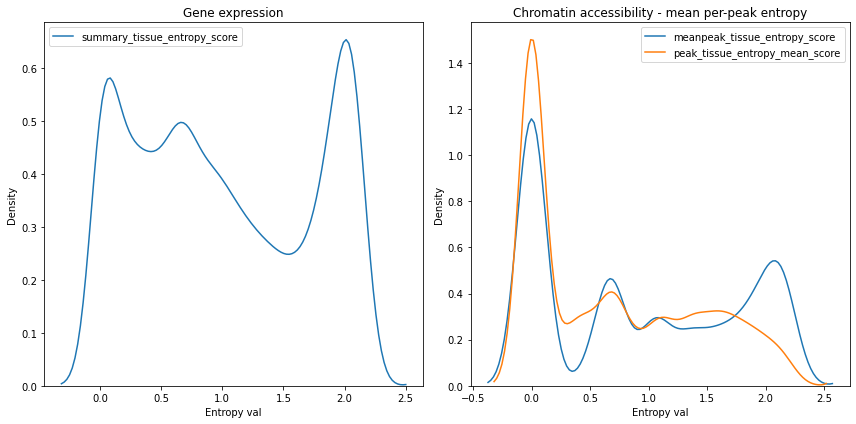

In [26]:
fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(12,6))

seaborn.kdeplot(data=l2_exp_data['summary_tissue_entropy_score'], ax=axes[0])
axes[0].set_xlabel('Entropy val')
axes[0].set_ylabel('Density')
axes[0].set_title('Gene expression')

seaborn.kdeplot(data=mean_overlaps['meanpeak_tissue_entropy_score'], ax=axes[1])
axes[1].set_xlabel('Entropy val')
axes[1].set_ylabel('Density')
axes[1].set_title('Chromatin accessibility - mean per-gene peak entropy')

seaborn.kdeplot(data=mean_overlaps['peak_tissue_entropy_mean_score'], ax=axes[1])
axes[1].set_xlabel('Entropy val')
axes[1].set_ylabel('Density')
axes[1].set_title('Chromatin accessibility - mean per-peak entropy')

fig.tight_layout()

## Compute z-score normalized entropy values to make them more comparable between peaks and genes

In [27]:
l2_exp_data['summary_tissue_entropy_zscore'] = l2_exp_data['summary_tissue_entropy_score'].to_numpy()
l2_exp_data.loc[~l2_exp_data['summary_tissue_entropy_score'].isnull(), 
                'summary_tissue_entropy_zscore'] = stats.zscore(l2_exp_data.loc[~l2_exp_data['summary_tissue_entropy_score'].isnull(), 'summary_tissue_entropy_score'].to_numpy())
mean_overlaps['meanpeak_tissue_entropy_zscore'] = stats.zscore(mean_overlaps['meanpeak_tissue_entropy_score'].to_numpy())
mean_overlaps['peak_tissue_entropy_mean_score_zscore'] = stats.zscore(mean_overlaps['peak_tissue_entropy_mean_score'].to_numpy())
mean_overlaps.head()

,gene_id,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,meanpeak_tissue_entropy_score,peak_tissue_entropy_mean_score,meanpeak_tissue_entropy_zscore,peak_tissue_entropy_mean_score_zscore
0,Gene:WBGene00000001,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.108364,-0.962522
1,Gene:WBGene00000002,1.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,1.166667,0.666667,1.348629,1.136787,0.522024,0.632998
2,Gene:WBGene00000003,0.600000,0.000000,0.600000,0.300000,0.000000,0.600000,0.800000,0.900000,0.600000,1.904448,1.323546,1.193966,0.895121
3,Gene:WBGene00000004,0.484848,0.848485,1.666667,1.242424,1.060606,1.545455,1.242424,1.333333,0.818182,2.145438,1.951227,1.485304,1.776093
4,Gene:WBGene00000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.909091,0.545455,0.000000,0.454545,1.052923,0.414941,0.164538,-0.380139


## Join the peak entropy results back into the full table to match up the entropy with gene common names

In [28]:
cols_to_join = ['gene_id', 'meanpeak_tissue_entropy_score', 'meanpeak_tissue_entropy_zscore', 
                'peak_tissue_entropy_mean_score', 'peak_tissue_entropy_mean_score_zscore']
num_peaks_per_gene = peak_int_w_gene_names[peak_int_w_gene_names['dist'] > -1200].groupby('gene_id').size().rename('peaks_per_gene')
peaks_w_entropy = peak_int_w_gene_names.join(num_peaks_per_gene, on='gene_id')
peaks_w_entropy = peaks_w_entropy.join(mean_overlaps[cols_to_join].set_index('gene_id'), on='gene_id')
peaks_w_entropy.head()

,peak_name,peak_tissue,gene_id,dist,peak_chrom,peak_score,peak_color,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,peak_overlap,seqid,source,type,score,strand,phase,biotype,peak_start,peak_end,within_2kb,within_1.2kb,peak_id,peak_len,center250_start,center250_end,locus,sequence_name,common_name,peaks_per_gene,meanpeak_tissue_entropy_score,meanpeak_tissue_entropy_zscore,peak_tissue_entropy_mean_score,peak_tissue_entropy_mean_score_zscore
0,37_peak_1000_chrII_8783538_8783821,sexmyoblast,Gene:WBGene00004790,-1,chrII,182,"249,127,192",0,1,0,0,0,1,1,0,1,4,chrII,WormBase,exon,.,-,.,protein_coding,8783538,8783821,True,True,37_peak_1000_chrII_8783538_8783821-sexmyoblast,283,8783554,8783804,sgn-1,F07H5.2,sgn-1,4.0,1.645348,0.880735,1.476688,1.110060
1,37_peak_1001_chrII_8784399_8784605,sexmyoblast,Gene:WBGene00014307,-1,chrII,131,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrII,WormBase,exon,.,+,.,pseudogene,8784399,8784605,True,True,37_peak_1001_chrII_8784399_8784605-sexmyoblast,206,8784377,8784627,NaN,F07H5.3,F07H5.3,11.0,2.170137,1.515163,2.139421,2.040229
3,37_peak_1002_chrII_8786064_8786264,sexmyoblast,Gene:WBGene00014308,-193,chrII,130,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrII,WormBase,exon,.,+,.,pseudogene,8786064,8786264,True,True,37_peak_1002_chrII_8786064_8786264-sexmyoblast,200,8786039,8786289,NaN,F07H5.4,F07H5.4,24.0,2.143591,1.483071,1.998176,1.841988
4,37_peak_1003_chrII_8787233_8787763,sexmyoblast,Gene:WBGene00014309,-7,chrII,286,"249,127,192",1,1,2,1,1,1,1,1,1,10,chrII,WormBase,exon,.,+,.,pseudogene,8787233,8787763,True,True,37_peak_1003_chrII_8787233_8787763-sexmyoblast,530,8787373,8787623,NaN,F07H5.5,F07H5.5,30.0,2.105031,1.436456,1.832510,1.609470
6,37_peak_1004_chrII_8789061_8789261,sexmyoblast,Gene:WBGene00014309,0,chrII,131,"249,127,192",0,0,0,1,1,1,1,0,1,5,chrII,WormBase,exon,.,+,.,pseudogene,8789061,8789261,True,True,37_peak_1004_chrII_8789061_8789261-sexmyoblast,200,8789036,8789286,NaN,F07H5.5,F07H5.5,30.0,2.105031,1.436456,1.832510,1.609470


## Try giving the genes a score based on how many peaks and how diverse the peaks are in terms of their overlap patterns

In [29]:
cols_to_select = ['gene_id'] + list(peaks_w_entropy.columns[peaks_w_entropy.columns.str.endswith('_overlaps')].values)
peak_diversity = peaks_w_entropy.loc[peaks_w_entropy['dist'] > -1200, cols_to_select].copy()
peak_diversity[cols_to_select[1:]] = peak_diversity[cols_to_select[1:]].apply(lambda x: x.to_numpy().astype(bool))
peak_diversity = peak_diversity[cols_to_select].drop_duplicates().groupby('gene_id').size().rename('peak_diversity').reset_index()
print(peak_diversity.shape)
peak_diversity.head()

(17502, 2)


,gene_id,peak_diversity
0,Gene:WBGene00000001,1
1,Gene:WBGene00000002,2
2,Gene:WBGene00000003,5
3,Gene:WBGene00000004,6
4,Gene:WBGene00000006,4


In [30]:
peaks_w_entropy = peaks_w_entropy.join(peak_diversity.set_index('gene_id'), on='gene_id')
print(peaks_w_entropy.shape)
peaks_w_entropy.head()

(146909, 41)


,peak_name,peak_tissue,gene_id,dist,peak_chrom,peak_score,peak_color,coelomocyte_overlaps,glia_overlaps,gonad_overlaps,hypodermis_overlaps,intestine_overlaps,muscle_overlaps,neuron_overlaps,pharynx_overlaps,sexmyoblast_overlaps,peak_overlap,seqid,source,type,score,strand,phase,biotype,peak_start,peak_end,within_2kb,within_1.2kb,peak_id,peak_len,center250_start,center250_end,locus,sequence_name,common_name,peaks_per_gene,meanpeak_tissue_entropy_score,meanpeak_tissue_entropy_zscore,peak_tissue_entropy_mean_score,peak_tissue_entropy_mean_score_zscore,peak_diversity
0,37_peak_1000_chrII_8783538_8783821,sexmyoblast,Gene:WBGene00004790,-1,chrII,182,"249,127,192",0,1,0,0,0,1,1,0,1,4,chrII,WormBase,exon,.,-,.,protein_coding,8783538,8783821,True,True,37_peak_1000_chrII_8783538_8783821-sexmyoblast,283,8783554,8783804,sgn-1,F07H5.2,sgn-1,4.0,1.645348,0.880735,1.476688,1.110060,2.0
1,37_peak_1001_chrII_8784399_8784605,sexmyoblast,Gene:WBGene00014307,-1,chrII,131,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrII,WormBase,exon,.,+,.,pseudogene,8784399,8784605,True,True,37_peak_1001_chrII_8784399_8784605-sexmyoblast,206,8784377,8784627,NaN,F07H5.3,F07H5.3,11.0,2.170137,1.515163,2.139421,2.040229,2.0
3,37_peak_1002_chrII_8786064_8786264,sexmyoblast,Gene:WBGene00014308,-193,chrII,130,"249,127,192",1,1,1,1,1,1,1,1,1,9,chrII,WormBase,exon,.,+,.,pseudogene,8786064,8786264,True,True,37_peak_1002_chrII_8786064_8786264-sexmyoblast,200,8786039,8786289,NaN,F07H5.4,F07H5.4,24.0,2.143591,1.483071,1.998176,1.841988,5.0
4,37_peak_1003_chrII_8787233_8787763,sexmyoblast,Gene:WBGene00014309,-7,chrII,286,"249,127,192",1,1,2,1,1,1,1,1,1,10,chrII,WormBase,exon,.,+,.,pseudogene,8787233,8787763,True,True,37_peak_1003_chrII_8787233_8787763-sexmyoblast,530,8787373,8787623,NaN,F07H5.5,F07H5.5,30.0,2.105031,1.436456,1.832510,1.609470,6.0
6,37_peak_1004_chrII_8789061_8789261,sexmyoblast,Gene:WBGene00014309,0,chrII,131,"249,127,192",0,0,0,1,1,1,1,0,1,5,chrII,WormBase,exon,.,+,.,pseudogene,8789061,8789261,True,True,37_peak_1004_chrII_8789061_8789261-sexmyoblast,200,8789036,8789286,NaN,F07H5.5,F07H5.5,30.0,2.105031,1.436456,1.832510,1.609470,6.0


## Join the tissue and peak entropy values on common name into a single dataframe for plotting against one another

In [31]:
cols_to_select = ['gene_id', 'common_name', 'peaks_per_gene', 'peak_diversity', 'meanpeak_tissue_entropy_score', 'meanpeak_tissue_entropy_zscore', 
                  'peak_tissue_entropy_mean_score', 'peak_tissue_entropy_mean_score_zscore']
to_plot = (peaks_w_entropy[cols_to_select].drop_duplicates()
           .join(l2_exp_data[['gene', 'summary_tissue_entropy_score', 'summary_tissue_entropy_zscore']].set_index('gene'), on='common_name'))
to_plot = to_plot[~to_plot['summary_tissue_entropy_score'].isnull()]
print(to_plot.shape)
to_plot.head()

(13680, 10)


,gene_id,common_name,peaks_per_gene,peak_diversity,meanpeak_tissue_entropy_score,meanpeak_tissue_entropy_zscore,peak_tissue_entropy_mean_score,peak_tissue_entropy_mean_score_zscore,summary_tissue_entropy_score,summary_tissue_entropy_zscore
0,Gene:WBGene00004790,sgn-1,4.0,2.0,1.645348,0.880735,1.476688,1.110060,0.759486,-0.361465
8,Gene:WBGene00011767,agxt-1,18.0,5.0,1.878637,1.162762,1.212633,0.739451,2.115198,1.532412
10,Gene:WBGene00011884,enol-1,34.0,6.0,2.119570,1.454031,1.846289,1.628808,1.958189,1.313077
12,Gene:WBGene00011885,T21B10.3,25.0,6.0,1.838399,1.114118,1.054514,0.517525,1.767615,1.046852
15,Gene:WBGene00018230,mage-1,2.0,1.0,0.000000,-1.108364,0.000000,-0.962522,1.961066,1.317096


(13680, 12)
(13111, 12)


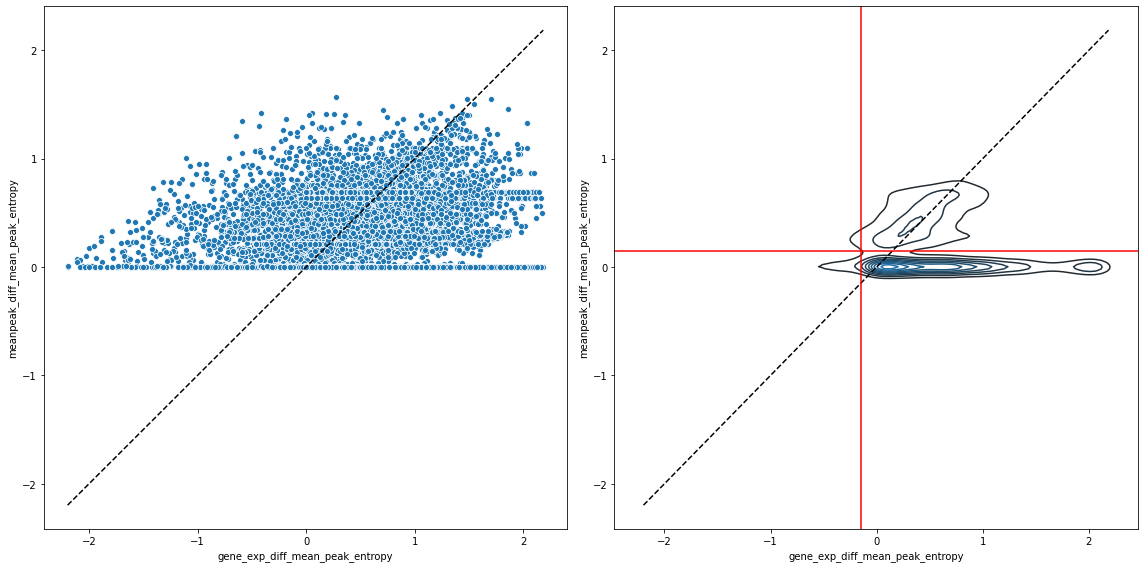

In [32]:
#I want to identify the genes with a diversity of peaks that roughly matches the gene expression diversity 
#(e.g. high entropy for mean peak if gene expression has high entropy), but with low entropy for any individual peak
#(e.g. low entropy for peak mean score if gene expression has high entropy). This should filter out cases where the 
#only reason the entropies differ is because of a lack of sci-ATAC-seq signal.
to_plot['gene_exp_diff_mean_peak_entropy'] = to_plot['summary_tissue_entropy_score'] - to_plot['peak_tissue_entropy_mean_score']
to_plot['meanpeak_diff_mean_peak_entropy'] = to_plot['meanpeak_tissue_entropy_score'] - to_plot['peak_tissue_entropy_mean_score']
print(to_plot.shape)
to_plot = to_plot[~to_plot['gene_exp_diff_mean_peak_entropy'].isnull()
                  & ~to_plot['meanpeak_diff_mean_peak_entropy'].isnull()
                  & ~to_plot['peak_diversity'].isnull()]
print(to_plot.shape)

fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(16,8))
seaborn.scatterplot(data=to_plot, x='gene_exp_diff_mean_peak_entropy', y='meanpeak_diff_mean_peak_entropy',
                    ax=axes[0])
minmax = [numpy.nanmin(to_plot[['gene_exp_diff_mean_peak_entropy', 'meanpeak_diff_mean_peak_entropy']].to_numpy()),
          numpy.nanmax(to_plot[['gene_exp_diff_mean_peak_entropy', 'meanpeak_diff_mean_peak_entropy']].to_numpy())]
axes[0].plot(minmax, minmax, color='k', linestyle='--')

seaborn.kdeplot(data=to_plot['gene_exp_diff_mean_peak_entropy'], data2=to_plot['meanpeak_diff_mean_peak_entropy'],
                ax=axes[1])
axes[1].plot(minmax, minmax, color='k', linestyle='--')
axes[1].axhline(0.15, color='r')
axes[1].axvline(-0.15, color='r')

fig.tight_layout()

(13111, 13)
(13111, 13)


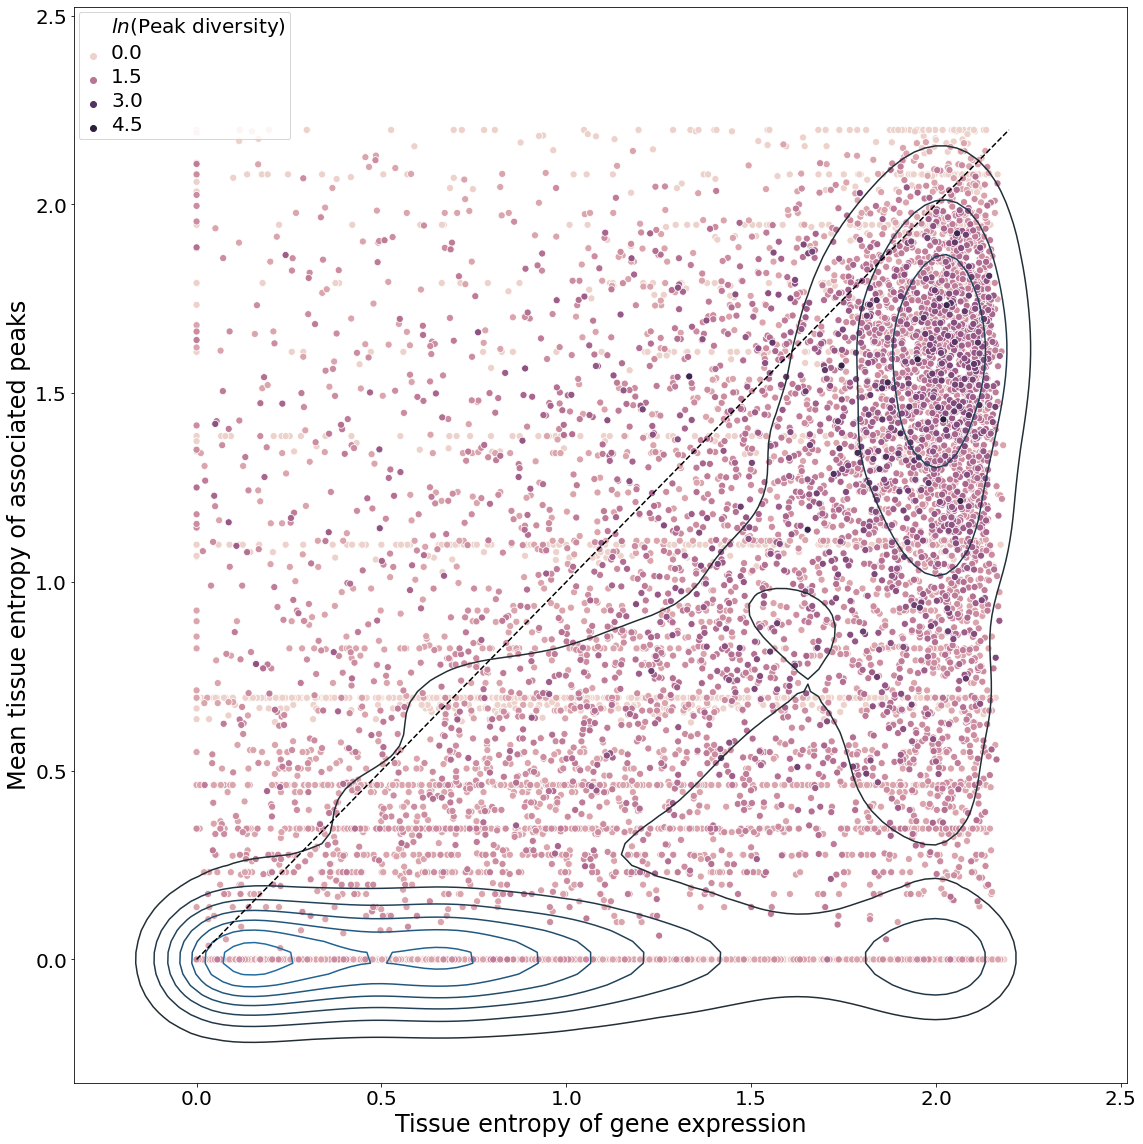

In [33]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(16,16))

to_plot['peak_diversity_log'] = numpy.log(to_plot['peak_diversity'])

to_plot_no_nan = to_plot[~to_plot['peak_tissue_entropy_mean_score'].isnull()
                         & ~to_plot['summary_tissue_entropy_score'].isnull()].sort_values(by='peak_diversity', 
                                                                                          ascending=True)
print(to_plot.shape)
print(to_plot_no_nan.shape)

minmax = [numpy.nanmin(to_plot_no_nan[['summary_tissue_entropy_score', 'peak_tissue_entropy_mean_score']].to_numpy()),
          numpy.nanmax(to_plot_no_nan[['summary_tissue_entropy_score', 'peak_tissue_entropy_mean_score']].to_numpy())]
seaborn.scatterplot(data=to_plot_no_nan,
                    x='summary_tissue_entropy_score', 
                    y='peak_tissue_entropy_mean_score',
                    hue='peak_diversity_log', s=50, ax=axes)
g = seaborn.kdeplot(data=to_plot_no_nan['summary_tissue_entropy_score'], 
                    data2=to_plot_no_nan['peak_tissue_entropy_mean_score'], ax=axes)
axes.plot(minmax, minmax, color='k', linestyle='--')
g.legend_.get_texts()[0].set_text('$ln$(Peak diversity)')
g.legend_.get_texts()[0].set_fontsize(20)
g.legend_.markerscale = 10
for t in g.legend_.get_texts()[1:]:
    t.set_fontsize(20)
axes.set_xlabel('Tissue entropy of gene expression', fontsize=24)
axes.set_ylabel('Mean tissue entropy of associated peaks', fontsize=24)
axes.set_xticklabels(axes.get_xticks(), fontsize=20)
axes.set_yticklabels(axes.get_yticks(), fontsize=20)
#axes[1].axhline(0.15, color='r')
#axes[1].axvline(-0.15, color='r')

fig.tight_layout()

In [34]:
to_investigate = (to_plot_no_nan[(to_plot_no_nan['peak_tissue_entropy_mean_score'] < 1.0)
                                 & (to_plot_no_nan['summary_tissue_entropy_score'] < 0.5)]
                  .sort_values(by='peak_diversity', ascending=False))
print(to_investigate.shape)
to_investigate.head(25)

(2661, 13)


,gene_id,common_name,peaks_per_gene,peak_diversity,meanpeak_tissue_entropy_score,meanpeak_tissue_entropy_zscore,peak_tissue_entropy_mean_score,peak_tissue_entropy_mean_score_zscore,summary_tissue_entropy_score,summary_tissue_entropy_zscore,gene_exp_diff_mean_peak_entropy,meanpeak_diff_mean_peak_entropy,peak_diversity_log
35764,Gene:WBGene00001537,gcy-11,20.0,9.0,1.447358,0.641380,0.782579,0.135854,0.160869,-1.197711,-0.621710,0.664779,2.197225
4612,Gene:WBGene00018716,F52H2.4,16.0,7.0,1.726896,0.979319,0.813977,0.179923,0.371015,-0.904145,-0.442963,0.912918,1.945910
28612,Gene:WBGene00004778,ser-3,10.0,6.0,1.318095,0.485111,0.456661,-0.321583,0.225905,-1.106858,-0.230756,0.861435,1.791759
43304,Gene:WBGene00006767,unc-31,11.0,6.0,1.519494,0.728587,0.657155,-0.040182,0.382694,-0.887830,-0.274461,0.862339,1.791759
176417,Gene:WBGene00018069,F35H10.3,7.0,6.0,1.204793,0.348138,0.445917,-0.336662,0.190644,-1.156116,-0.255273,0.758876,1.791759
16079,Gene:WBGene00004316,rbf-1,27.0,5.0,1.564942,0.783530,0.464996,-0.309884,0.396642,-0.868345,-0.068355,1.099946,1.609438
4956,Gene:WBGene00022202,Y72A10A.1,10.0,5.0,1.760004,1.019344,0.744384,0.082246,0.420306,-0.835287,-0.324078,1.015620,1.609438
73821,Gene:WBGene00018837,F54G2.1,15.0,5.0,1.105127,0.227649,0.358352,-0.459563,0.333899,-0.955994,-0.024453,0.746775,1.609438
22090,Gene:WBGene00001189,egl-21,11.0,5.0,1.401393,0.585811,0.771061,0.119689,0.180023,-1.170954,-0.591038,0.630332,1.609438
14212,Gene:WBGene00009738,hecw-1,12.0,5.0,2.130161,1.466836,0.917079,0.324629,0.275587,-1.037454,-0.641491,1.213083,1.609438


In [35]:
to_investigate = (to_plot_no_nan[(to_plot_no_nan['peak_tissue_entropy_mean_score'] > 1.0)
                                 & (to_plot_no_nan['summary_tissue_entropy_score'] > 1.75)]
                  .sort_values(by='peak_diversity', ascending=False))
print(to_investigate.shape)
to_investigate.head(209)

(2700, 13)


,gene_id,common_name,peaks_per_gene,peak_diversity,meanpeak_tissue_entropy_score,meanpeak_tissue_entropy_zscore,peak_tissue_entropy_mean_score,peak_tissue_entropy_mean_score_zscore,summary_tissue_entropy_score,summary_tissue_entropy_zscore,gene_exp_diff_mean_peak_entropy,meanpeak_diff_mean_peak_entropy,peak_diversity_log
3728,Gene:WBGene00018700,lmd-3,80.0,34.0,2.129288,1.465780,1.430408,1.045106,2.020066,1.399516,0.589657,0.698879,3.526361
3057,Gene:WBGene00003150,mbk-2,86.0,31.0,2.154485,1.496241,1.589585,1.268516,1.950522,1.302366,0.360937,0.564900,3.433987
4281,Gene:WBGene00003916,par-1,79.0,28.0,2.070738,1.394998,1.214547,0.742137,2.066183,1.463940,0.851636,0.856191,3.332205
7133,Gene:WBGene00001194,egl-27,145.0,27.0,2.166926,1.511282,1.923291,1.736884,2.057373,1.451634,0.134082,0.243635,3.295837
4321,Gene:WBGene00002783,let-607,72.0,26.0,2.128210,1.464477,1.733060,1.469887,2.029083,1.412113,0.296023,0.395150,3.258097
6522,Gene:WBGene00000912,daf-16,68.0,25.0,2.113273,1.446420,1.528359,1.182582,1.869498,1.189179,0.341139,0.584915,3.218876
6752,Gene:WBGene00002189,kin-1,69.0,23.0,2.135844,1.473706,1.393463,0.993252,1.904249,1.237724,0.510786,0.742381,3.135494
1540,Gene:WBGene00015418,pac-1,69.0,23.0,2.041099,1.359166,1.342042,0.921080,1.788099,1.075467,0.446057,0.699057,3.135494
5291,Gene:WBGene00009888,F49E2.5,64.0,21.0,2.132324,1.469451,1.468451,1.098500,2.117601,1.535769,0.649150,0.663873,3.044522
6996,Gene:WBGene00006923,vhp-1,92.0,21.0,2.067364,1.390918,1.746419,1.488638,1.839724,1.147586,0.093305,0.320944,3.044522


In [319]:
to_investigate = (to_plot_no_nan[(to_plot_no_nan['peak_tissue_entropy_mean_score'] < 1.0)
                                 & (to_plot_no_nan['summary_tissue_entropy_score'] > 1.5)]
                  .sort_values(by='peak_diversity', ascending=False))
print(to_investigate.shape)
to_investigate.head(209)

(2038, 14)


,gene_id,common_name,peaks_per_gene,peak_diversity,meanpeak_tissue_entropy_score,meanpeak_tissue_entropy_zscore,peak_tissue_entropy_mean_score,peak_tissue_entropy_mean_score_zscore,summary_tissue_entropy_score,summary_tissue_entropy_zscore,gene_exp_diff_mean_peak_entropy,meanpeak_diff_mean_peak_entropy,peak_diversity_zscore,peak_diversity_log
3618,Gene:WBGene00006815,unc-83,33.0,16.0,1.950348,1.249456,0.744147,0.081915,2.081045,1.484701,1.336897,1.206201,6.047729,2.772589
4217,Gene:WBGene00011647,noca-1,48.0,16.0,1.857308,1.136978,0.931697,0.345147,1.956404,1.310584,1.024707,0.925611,6.047729,2.772589
7481,Gene:WBGene00011755,T13H5.1,39.0,15.0,1.815133,1.085991,0.815444,0.181982,1.551583,0.745064,0.736139,0.999689,5.601382,2.708050
5275,Gene:WBGene00001516,gap-2,36.0,14.0,1.793537,1.059883,0.509635,-0.247231,1.625064,0.847714,1.115428,1.283901,5.155035,2.639057
26232,Gene:WBGene00019237,H24G06.1,40.0,14.0,1.700098,0.946922,0.938438,0.354609,1.941480,1.289735,1.003042,0.761659,5.155035,2.639057
6135,Gene:WBGene00019347,mbl-1,31.0,14.0,1.816062,1.087115,0.890514,0.287345,1.570511,0.771506,0.679997,0.925548,5.155035,2.639057
2902,Gene:WBGene00004892,sms-1,29.0,14.0,1.805546,1.074401,0.778620,0.130299,1.618802,0.838966,0.840182,1.026926,5.155035,2.639057
5257,Gene:WBGene00016006,fln-2,58.0,14.0,1.589751,0.813522,0.748294,0.087734,1.840805,1.149095,1.092511,0.841458,5.155035,2.639057
6909,Gene:WBGene00004751,sea-2,31.0,14.0,1.856680,1.136218,0.869213,0.257449,2.032672,1.417126,1.163458,0.987466,5.155035,2.639057
26222,Gene:WBGene00002036,hum-2,44.0,14.0,1.679052,0.921480,0.868561,0.256533,1.802987,1.096266,0.934426,0.810491,5.155035,2.639057


In [323]:
(to_investigate['peak_diversity'] > 4).sum()

208

In [321]:
(to_investigate['peak_diversity'] > 1).sum()

1243

In [324]:
(to_investigate[['common_name', 'peak_diversity', 'peak_tissue_entropy_mean_score', 'summary_tissue_entropy_score']]
 .to_csv('./broadly_expressed_genes_with_tissue_specific_accessibility.csv', index=False))